# Simulating Noisy Dataset

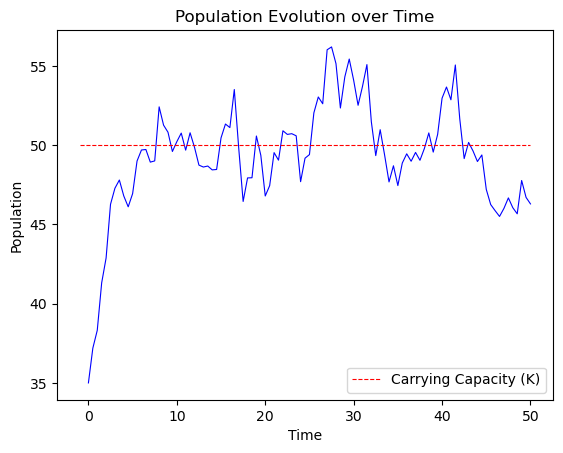

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

r = 0.3
σ = 0.04
K = 50
P0 = 35

T = 50
N = 100
t = np.linspace(0,T,N+1)
h = T/N

dW = np.random.normal(0,np.sqrt(h), N)
P = np.zeros(N+1)
P[0] = P0

def a(P):
    return r*P*(1-P/K)         
def b(P):
    return σ*P
        
for i in range(N):
    P[i+1] = P[i]+a(P[i])*h+b(P[i])*(dW[i])
    
plt.plot(t,P, 'b',linewidth = 0.8)
plt.hlines(y = K, xmin=-1,xmax=50, color = 'r', linestyle = '--', linewidth = 0.8, label = 'Carrying Capacity (K)')
plt.title('Population Evolution over Time')
plt.legend(loc = 'lower right')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [19]:
data = np.column_stack((t,P))
df = pd.DataFrame(data, columns=['Timestamp', 'Population'])
df.head() # First few rows of the generated dataset

,Timestamp,Population
0,0.0,35.000000
1,0.5,37.194188
2,1.0,38.318544
3,1.5,41.316176
4,2.0,42.885048


# Parameter Estimation using MLE 

## Finding maximizer analytically

In [20]:
from scipy.optimize import fsolve

def equations(vars):
    r,σ,K=vars
    eq1=np.sum([(P[i]/P[i-1]-1-r*h*(1-P[i-1]/K))**2 for i in range(1,N+1)])-σ**2*N*h
    eq2=np.sum([(P[i]/P[i-1]-1-r*(1-P[i-1]/K)*h)*((P[i-1]/K)-1) for i in range(1,N+1)])
    eq3=np.sum([(P[i]/P[i-1]-1-r*(1-P[i-1]/K)*h)*P[i-1] for i in range(1,N+1)])
    return [eq1,eq2,eq3]

r0 = 0.3
σ0 = 0.04
K0 = 50
initial_guess=[r0,σ0,K0]
solution=fsolve(equations,initial_guess)
r_est,sigma_est,K_est=solution

print(f"Estimated r:{r_est:.3f}")
print(f"Estimated σ:{sigma_est:.3f}")
print(f"Estimated K:{K_est:.3f}")

Estimated r:0.419
Estimated σ:0.041
Estimated K:50.126


## Finding Maximizer using inbuilt function  

In [21]:
import scipy as sc

def l1(params): # log likelihood for stochastic model
    r,σ,K = params
    a = 0
    b = 0
    for i in range(1,N+1):
        a = a+((P[i]-P[i-1]-r*P[i-1]*(1-P[i-1]/K)*h)/P[i-1])**2
        b = b+np.log(P[i-1])
    return -(-N*np.log(np.sqrt(2*np.pi))-N*np.log(σ)-N*np.log(np.sqrt(h))-b-1/(2*σ**2*h)*a)

r0 = 0.3
σ0 = 0.04
K0 = 50
result = sc.optimize.minimize(l1, [r0,σ0,K0], method='BFGS')
r̂1,σ̂1,K̂1 = result.x
print(f'Estimated r: r̂ = {r̂1:.03f}')
print(f'Estimated σe: σ̂e = {σ̂1:.03f}')
print(f'Estimated K: K̂ = {K̂1:.03f}')

Estimated r: r̂ = 0.419
Estimated σe: σ̂e = 0.041
Estimated K: K̂ = 50.126


From both ways, we get the same value of parameters

In [22]:
def l2(params): # log likelihood for deterministic model
    r,σ,K = params
    a = 0
    for i in range(1,N+1):
        a = a+(P[i]-P[i-1]-r*P[i-1]*(1-P[i-1]/K)*h)**2
    return -(-N*np.log(np.sqrt(2*np.pi))-N*np.log(σ)-1/(2*σ**2)*a)

r0 = 0.3
σ0 = 2
K0 = 50
result = sc.optimize.minimize(l2, [r0,σ0,K0], method='BFGS')
r̂2,σ̂2,K̂2 = result.x
print(f'Estimated r: r̂ = {r̂2:.03f}')
print(f'Estimated σ: σ̂ = {σ̂2:.03f}')
print(f'Estimated K: K̂ = {K̂2:.03f}')

Estimated r: r̂ = 0.413
Estimated σ: σ̂ = 1.441
Estimated K: K̂ = 50.132


In [23]:
def l1(r,σ,K): # log likelihood for stochastic model
    a = 0
    b = 0
    for i in range(1,N+1):
        a = a+((P[i]-P[i-1]-r*P[i-1]*(1-P[i-1]/K)*h)/P[i-1])**2
        b = b+np.log(P[i-1])
    return (-N*np.log(np.sqrt(2*np.pi))-N*np.log(σ)-N*np.log(np.sqrt(h))-b-1/(2*σ**2*h)*a)

def l2(r,σ,K): # log likelihood for deterministic model
    a = 0
    for i in range(1,N+1):
        a = a+(P[i]-P[i-1]-r*P[i-1]*(1-P[i-1]/K)*h)**2
    return -N*np.log(np.sqrt(2*np.pi))-N*np.log(σ)-1/(2*σ**2)*a

AIC1 = 6-2*l1(r̂1,σ̂1,K̂1) # AIC for stochastic model
AIC2 = 6-2*l2(r̂2,σ̂2,K̂2) # AIC for deterministic model
print(f'AIC for stochastic model: {AIC1:.2f}')
print(f'AIC for deterministic model: {AIC2:.2f}')

AIC for stochastic model: 358.78
AIC for deterministic model: 362.89
